# Classification calculs urinaires
**Clément Cottet**

On va créer un classifieur pour classifier des images de calculs urinaires. Ces images sont stockés dans le dataset 'dataset_calculs/'. On va donc commencer par récupérer ces images.

In [21]:
import os
from PIL import Image
import numpy as np

dataset_root = '/home/jpc/Dev/5A/CODEV_D/dataset/'

x = []
y = []
# Récupération des images et des labels
for dirpath, directories, files in os.walk(dataset_root):
    for file in files:
        if '.jpg' in file or '.png' in file:
            img = np.array(Image.open(os.path.join(dirpath, file)).resize((500, 500)))
            img = img[:,:,:3] # removing the 4th channel (transparency in png) if present
            x.append(img)
            label = os.path.basename(file.split('_')[0])
            y.append(label.lower())
x = np.array(x)
y = np.array(y)

# Transformation des labels en entier
labels = np.unique(y)
int_y = []
for value in labels:
    int_y.append(np.where(labels == value))
y = np.array(int_y)
y = np.reshape(y, (len(y), ))

print(x.shape)
print(y.shape)
print(labels)

(203, 500, 500, 3)
(16,)
['ia' 'ib' 'ic' 'id' 'ie' 'iia' 'iib' 'iiia' 'iiib' 'iva1' 'iva2' 'ivb'
 'ivc' 'ivd' 'va' 'via']


Regardons maintenant la distribution des classes de calculs dans le dataset.

0 ia
1 ib
2 ic
3 id
4 ie
5 iia
6 iib
7 iiia
8 iiib
9 iva1
10 iva2
11 ivb
12 ivc
13 ivd
14 va
15 via


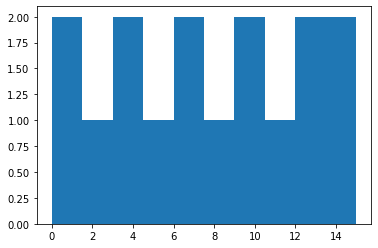

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, label in enumerate(labels):
    print(i, label)
    
plt.hist(y)
plt.show()

## Extraction des "features" des images
On va maintenant utiliser un réseau convolutionnel pré-entraîné (VGG16) sur le dataset 'Imagenet' pour extraire des features des images de calculs à partir des couches convolutionnelles. 

In [3]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=x[0].shape)
features = vgg16.predict(x)
features.shape

Instructions for updating:
Colocations handled automatically by placer.


(354, 15, 15, 512)

On doit maintenant applatir les sorties des convolutions pour les données à un modèle de machine learning plus classique.

In [4]:
new_x = []
for feature in features:
    new_x.append(feature.flatten())
x = np.array(new_x)
x.shape

(354, 115200)

## Séparation du dataset en test et entraînement
On va séparer le dataset en dataset de test et en dataset d'entraînement. Pour cela on commence par mélanger le dataset, puis on va ensuite le séparer en deux parties selon les proportions 70/30.

In [5]:
# Mélange du dataset
shuffled_indices = np.arange(len(x))
np.random.shuffle(shuffled_indices)
x = x[shuffled_indices]
y = y[shuffled_indices]

# Séparation en test et entraînement 30/70
split_indice = int(0.7 * len(x))
x_train = x[:split_indice - 1]
y_train = y[:split_indice - 1]
x_test = x[split_indice:]
y_test = y[split_indice:]
print(x_train.shape)
print(x_test.shape)

(246, 115200)
(107, 115200)


## Entraînement
On va maintenant entraîner un modèle de machine learning avec les features extraites des images et les labels. Pour cela, on utilise GridSearchCV pour sélectionner les meilleurs paramètres et choisir le meilleur modèle avec de la cross-validation.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 250],
    'max_depth': [25, 50, 100, 500, 1000]
}
grid = GridSearchCV(rf, param_grid, cv=5)
grid.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 250], 'max_depth': [25, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [7]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 500, 'n_estimators': 250}
0.8739837398373984


In [8]:
model = grid.best_estimator_

## Test
On peut maintenant tester notre modèle sur les données des test mises de côté.

In [9]:
from sklearn.metrics import accuracy_score, f1_score
test_predictions = model.predict(x_test)

accuracy = accuracy_score(y_test, test_predictions)
f1_score_macro = f1_score(y_test, test_predictions, average='macro')
f1_score_weighted = f1_score(y_test, test_predictions, average='weighted')
print('Test accuracy: ', accuracy)
print('F1 score (macro): ', f1_score_macro)
print('F1 score (weighted): ', f1_score_weighted)

Test accuracy:  0.9065420560747663
F1 score (macro):  0.8919224589886691
F1 score (weighted):  0.9062034231560113


Confusion matrix, without normalization
[[22  0  0  1]
 [ 1  5  0  0]
 [ 1  1 33  5]
 [ 1  0  0 37]]


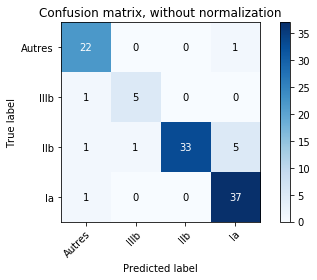

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_test, test_predictions, labels)
plt.show()

Normalized confusion matrix
[[0.95652174 0.         0.         0.04347826]
 [0.16666667 0.83333333 0.         0.        ]
 [0.025      0.025      0.825      0.125     ]
 [0.02631579 0.         0.         0.97368421]]


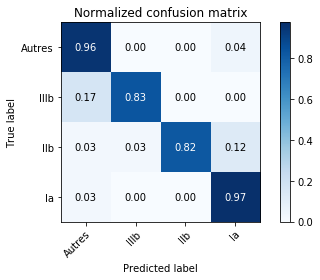

In [11]:
plot_confusion_matrix(y_test, test_predictions, labels, normalize=True)
plt.show()

## Sauvegarde
Il ne reste plus qu'à sauvegarder le modèle.

In [14]:
import datetime
from joblib import dump

now = datetime.datetime.now()
dump(model, './models/' + '{:1.3f}'.format(accuracy) + '_' + str(now))

['./models/0.907_2019-05-11 11:54:50.466169']